**Importing Library and Installing Packages**

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Download Dataset using kaggle**

In [3]:
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d phylake1337/fire-dataset

Saving kaggle.json to kaggle.json
 97% 377M/387M [00:14<00:00, 23.8MB/s]
100% 387M/387M [00:14<00:00, 28.6MB/s]


**Load Dataset and Saving images**

In [4]:
path = os.getcwd()

data = path + '/fire-dataset.zip'
zip_ref = zipfile.ZipFile(data, 'r')
zip_ref.extractall(path)

zip_ref.close()

os.listdir()

data_dir = path + '/fire_dataset'

data_fire_dir = os.path.join(data_dir, 'fire_images')
data_nonfire_dir = os.path.join(data_dir, 'non_fire_images')

**Training and Validation Generators**

In [5]:
def train_val_generators(data_dir):

  datagen = ImageDataGenerator(
      rescale = 1/255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)
  
  train_generator= datagen.flow_from_directory(
        data_dir,
        target_size=(150,150),
        class_mode='binary',
        batch_size=32,
        subset='training')

  validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(150,150),
        class_mode='binary',
        batch_size=32,
        subset='validation')
  
  return train_generator, validation_generator

train_generator, validation_generator = train_val_generators(data_dir)

Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


**Model**

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

**Callbacks**

In [7]:
class myCallback(tf.keras.callbacks.Callback):
           
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy')) > 0.99: 
                print("\nReached 99% accuracy so cancelling training!")    
                self.model.stop_training = True

# Initiate callbacks
callbacks = myCallback()

In [8]:
history = model.fit(train_generator, epochs=10, validation_data = validation_generator, verbose = 1, validation_steps=3, callbacks=myCallback())

Epoch 1/10
25/25 [==============================] - 140s 5s/step - loss: 2.1767 - accuracy: 0.7550 - val_loss: 0.2730 - val_accuracy: 0.9271
Epoch 2/10
25/25 [==============================] - 129s 5s/step - loss: 0.3334 - accuracy: 0.8988 - val_loss: 0.2147 - val_accuracy: 0.9167
Epoch 3/10
25/25 [==============================] - 129s 5s/step - loss: 0.2543 - accuracy: 0.9175 - val_loss: 0.2395 - val_accuracy: 0.9167
Epoch 4/10
25/25 [==============================] - 127s 5s/step - loss: 0.2201 - accuracy: 0.9087 - val_loss: 0.2092 - val_accuracy: 0.9062
Epoch 5/10
25/25 [==============================] - 128s 5s/step - loss: 0.2493 - accuracy: 0.9150 - val_loss: 0.1091 - val_accuracy: 0.9688
Epoch 6/10
25/25 [==============================] - 129s 5s/step - loss: 0.2788 - accuracy: 0.9400 - val_loss: 0.3831 - val_accuracy: 0.8125
Epoch 7/10
25/25 [==============================] - 128s 5s/step - loss: 0.1545 - accuracy: 0.9375 - val_loss: 0.1790 - val_accuracy: 0.9167
Epoch 8/10
25

**CNN Model Baseline**

In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 256)      0

Convert to **Tflite** and **h5** (Optional)

In [10]:
export_dir = 'saved_model/1'

tf.saved_model.save(model,export_dir=export_dir)

# Mode of optimization
mode = "Default" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model, Uncomment below if you want tflite model
# tflite_model = converter.convert()

# tflite_model_file = pathlib.Path('./model.tflite')
# tflite_model_file.write_bytes(tflite_model)

# Converting to h5 model
tf.keras.models.save_model(model, "./model.h5")

INFO:tensorflow:Assets written to: saved_model/1/assets


**Predict** an image

0.00010 % non-fire
99.99990 % fire


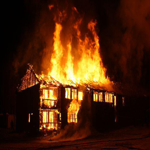

In [11]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np

# Open image using URL
response = requests.get('https://cdn.pixabay.com/photo/2017/11/13/16/05/fire-2946038__480.jpg')
image = Image.open(BytesIO(response.content)).resize((150, 150)).convert('RGB')

# Open image using path location
# Error prediction at R_101
# image = Image.open('/content/TRAIN/R/R_101.jpg').resize((150, 150))

temp = np.asarray(image)*(1/255)
temp = np.expand_dims(temp, axis=(0))

non_fire_prediction = model.predict(temp)[0][0] * 100
print(f'{non_fire_prediction:.5f} % non-fire')
print(f'{100 - non_fire_prediction:.5f} % fire')
display(image)